In [1]:
library(dplyr) # for data manipulation and transformation
library(tidyverse) # for a collection of packages for data manipulation and visualization
library(stats) # for statistical functions and models
library(tsfeatures)
library(lubridate)
library(runner)

library(TSdist) # for calculating distance measures between time series
library(forecast) # for time series forecasting
library(TSA) # for time series analysis
library(tseries)
library(signal)
library(imputeTS)

library(ggplot2) # for creating beautiful and customizable visualizations
library(gridExtra) # for arranging multiple plots on a grid
library(RColorBrewer) # for creating color palettes for your plots
library(MLmetrics)
library(summarytools)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ─────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.4.4     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ───────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: proxy


Attaching package: 'proxy'


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix


Loaded TSdist v3.

In [4]:
# path definitions

DATA_PATH <- "data/"

DATA_INFO <- paste0(DATA_PATH,"info/")
DATA_INFO_NIBIO_FILE <- paste0(DATA_INFO ,"lmt.nibio.csv")
DATA_INFO_FROST_FILE <- paste0(DATA_INFO,"Frost_stations.csv")
DATA_FILE_SOIL_STATIONS <- paste0(DATA_INFO,"'Stasjonsliste jordtemperatur modellering.xlsx'")

DATA_COLLECTION <- paste0(DATA_PATH,"raw_data/")
DATA_COLLECTION_STAT <- paste0(DATA_COLLECTION,"Veret paa Aas 2013- 2017/") # pattern -> 'Veret paa Aas 2013- 2017/Veret paa Aas {YYYY}.pdf'
DATA_COLLECTION_TIME <- paste0(DATA_COLLECTION,"Time 2013- 2023/") # pattern -> Time{YYYY}.xlsx
DATA_COLLECTION_NIBIO <- paste0(DATA_COLLECTION,"nibio/") # pattern -> weather_data_hour_stID{id}_y{year}.csv

# ID definitions

nibio_id = c(
    108,10,14,29,48,51,15,16,17,18,20,23,25,26,27,57,31,30,35,37,39,48,49,51,54
)

# function definitions

file_name.nibio <- function(station_id, year, path = NULL){
    if(is.null(path)){
        pattern = paste0(DATA_COLLECTION_NIBIO,"weather_data_hour_stID",station_id,"_y",year,".csv")
    } else {
        pattern = sprintf(path,station_id,year)
    }
    return(pattern)
}

data.nibio <- function(station_id,year, path = NULL){
    path <- file_name.nibio(station_id,year, path = path)
    data_nibio <- read.csv(path,
                       header=T, col.names = c("Time","TM","RR","TJM10","TJM20"))
    data_nibio <- mutate(data_nibio,across(
                                    "Time",
                                  str2date))
    data_nibio <- column_to_rownames(data_nibio, var = "Time")
    data_nibio <- mutate_at(data_nibio,c("TM","RR","TJM10","TJM20"), as.numeric)
    return(data_nibio)
}
na.interpol.cust <- function(data, maxgap = Inf, n.p, 
                             s.window = 10, alg.option = "linear"){
    data.decomp <- stlplus::stlplus(data,n.p = n.p, s.window = s.window)
    data.new <- rep(0,length.out = length(data))
    for(part in c("seasonal", "trend", "remainder")){
        data.new <- data.new + na_interpolation(data.decomp$data[,part],
                                                maxgap=maxgap,
                                                option = alg.option)
    }
    return(data.new)
}
str2date <- function(x) {
    return(as.POSIXlt(paste0(x,"00"),
                      format = "%Y-%m-%d %H:%M:%S%z",
                      tz="GMT"))
}

na.interplol.kal <-function(data, maxgap = Inf, n.p, 
                             s.window = 10, alg.option = "StructTS"){
    data.decomp <- stlplus::stlplus(data,n.p = n.p, s.window = s.window)
    data.new <- rep(0,length.out = length(data))
    for(part in c("seasonal", "trend", "remainder")){
        data.new <- data.new + na_kalman(data.decomp$data[,part],
                                                maxgap=maxgap,
                                                model = alg.option,
                                        smooth = TRUE)
    }
    return(data.new)
}

find.index.rle <- function(x,l,v){
    i <- 1
    k <- 1
    for(r in x$lengths){
        if(r == l && x$values[k] == v) {
            return(c(i,i+r-1))
        } else {
            i <- i + r
        }
        k <- k + 1
    }
    return(-1)
}

find.index.rle.bool <- function(x,l){
    return(find.index.rle(x,l,TRUE))
}

## Data behandling

Henter data fra csv filer som er hentet fra NiBio

In [3]:
station_names <- read.csv(DATA_INFO_NIBIO_FILE,
                          header=TRUE,
                          row.names="ID",
                          colClasses=c(ID="integer",Navn="character"))

In [20]:
nrow(station_names)
for(ID in nibio_id){
    print(paste(ID, ":", station_names[as.character(ID),]))
}

[1] 84

[1] "108 :  Skjetten"
[1] "10 :  Alvdal"
[1] "14 :  Etne"
[1] "29 :  Landvik"
[1] "48 :  Særheim"
[1] "51 :  Tjøtta"
[1] "15 :  Frosta"
[1] "16 :  Fureneset"
[1] "17 :  Fåvang"
[1] "18 :  Gausdal"
[1] "20 :  Gran"
[1] "23 :  Hokksund"
[1] "25 :  Hønefoss"
[1] "26 :  Ilseng"
[1] "27 :  Kise"
[1] "57 :  Kvithamar"
[1] "31 :  Linge"
[1] "30 :  Lier"
[1] "35 :  Njøs"
[1] "37 :  Rakkestad"
[1] "39 :  Rissa"
[1] "48 :  Særheim"
[1] "49 :  Tingvoll"
[1] "51 :  Tjøtta"
[1] "54 :  Ullensvang"


In [61]:
print(command)

[1] " 10 , 11 , 12 , 145 , 143 , 13 , 86 , 133 , 14 , 127 , 140 , 15 , 16 , 17 , 18 , 19 , 20 , 110 , 21 , 121 , 87 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 93 , 57 , 29 , 149 , 141 , 30 , 31 , 65 , 62 , 32 , 33 , 82 , 71 , 34 , 104 , 35 , 90 , 81 , 147 , 36 , 37 , 38 , 97 , 83 , 130 , 39 , 40 , 41 , 63 , 42 , 131 , 134 , 142 , 43 , 108 , 44 , 64 , 129 , 45 , 46 , 47 , 123 , 48 , 91 , 49 , 50 , 51 , 52 , 54 , 55 , 144 , 118 , 53 , 5 , 61 , 72 ,"


## Imputerings metode

Undersøker om dekomponering er bedre enn naiv imputering

In [26]:
blocks.index <- c()
len.na <- 8
len.val <- 12

data.check <- 1:5880
i <- 0
while(i < 5880){
    i <- i + len.val - 1
    blocks.index <- append(blocks.index,seq(i,i+len.na-1))
    i <- i + len.na
}
blocks.index <- blocks.index[blocks.index <= 5880]

Warning message in stats::spline(indx, data_vec[indx], n = n, ...):
"spline: first and last y values differ - using y[1] for both"


[1] "µ 0.00617556270789108 std: 1.04896214408653 skewness: -0.144042207521844"


Warning message in stats::spline(indx, data_vec[indx], n = n, ...):
"spline: first and last y values differ - using y[1] for both"


[1] "µ 0.00689338307627739 std: 1.66681294760379 skewness: -0.27876858498954"


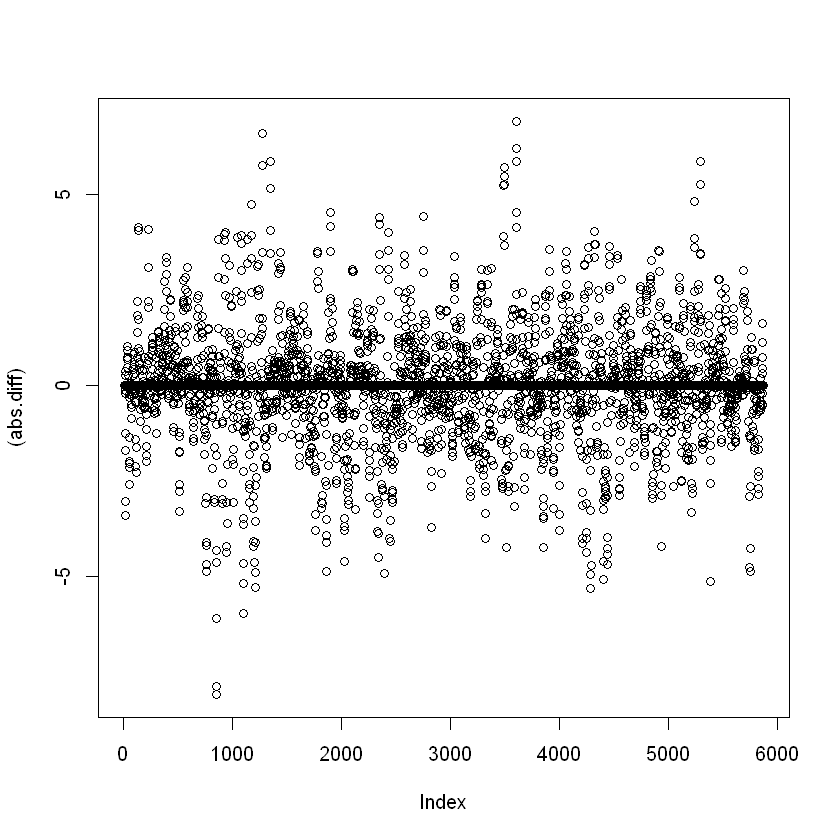

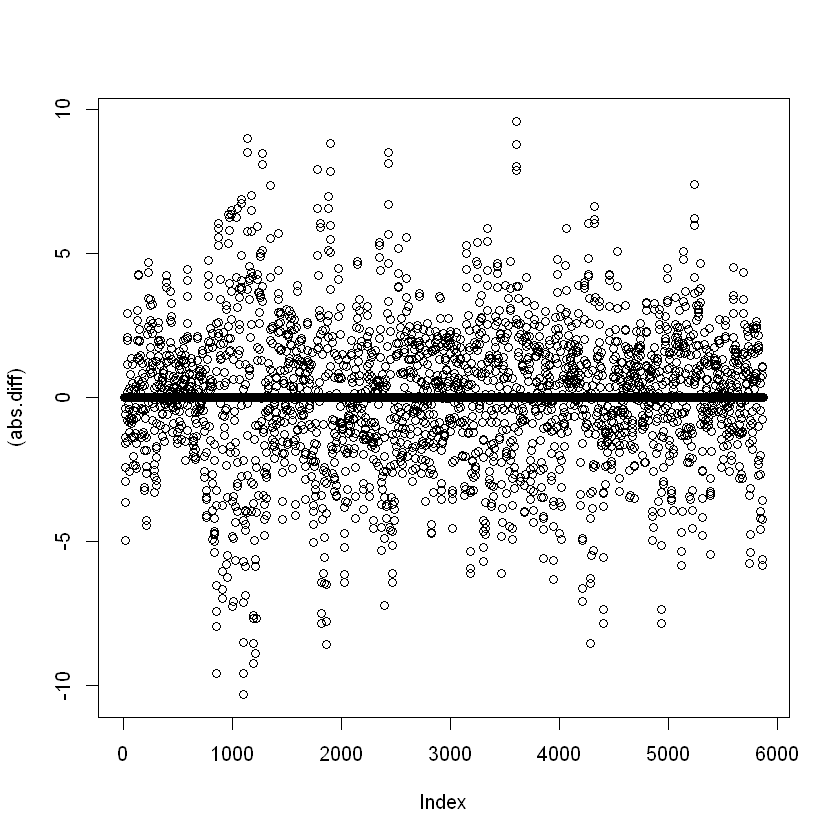

In [35]:
#library(moments)
data_nibio_no_na <- data.nibio(14,2019)
col.name <- "TM"

faulty.data <- data_nibio_no_na
faulty.data[blocks.index,col.name] <- NA

fixed.data <- na_interpolation(faulty.data[,col.name], option="spline", method = "periodic")
abs.diff <- fixed.data - data_nibio_no_na[,col.name]
print(paste("µ",mean(abs.diff),"std:",sqrt(var(abs.diff)),"skewness:",skewness(abs.diff)))
plot((abs.diff),xlim = c(0,5880))

fixed.data <- na.interpol.cust(faulty.data[,col.name], n.p = 21,alg.option="spline", method = "periodic")
abs.diff <- fixed.data - data_nibio_no_na[,col.name]
print(paste("µ",mean(abs.diff),"std:",sqrt(var(abs.diff)),"skewness:",skewness(abs.diff)))
plot((abs.diff),xlim = c(0,5880))

## Data Analyse

Analyserer data for avvik.

In [34]:

feature.name = c("TM","RR","TJM10","TJM20")
na.run.tables <- c()
full.count <- c()

notible_run <- 24*7
warning_run <- 8*2 # imputering fra begge ender

cat("Null count of data.",
            file = "data.txt",sep="\n")
cat(paste("notable runs,defined by nb length",notible_run,"and warning length",warning_run,"\n###############################"),
            file = "NB_data.txt",sep="\n")

station_names <- read.csv(DATA_INFO_NIBIO_FILE,
                          header=TRUE,
                          row.names="ID",
                          colClasses=c(ID="integer",Navn="character"))

na.run.station.year.feature <- list()

sub_set <- c(
    108,10,14,29,48,51,15,16,17,18,20,23,25,26,27,57,31,30,35,37,39,48,49,51,54
)

for(id in sub_set){
    numb <- 0
    denom <- 0
    na.run.count <- matrix(rep(0,length=5880*4),nrow = 5880, ncol = 4)
    colnames(na.run.count) <- feature.name
    na.count <- c()
    na.count.year <- c()
    na.run.station.year.feature[[as.character(id)]] <- c()
    #data_plot <- ggplot(title = paste("NA count of staion:",station_names[as.character(id),],"id:",id))
    na.plot <- FALSE
    cat(paste("***************","station",id,"***************"),append=T,sep="\n",file = "NB_data.txt")
    for(year in seq(2014,2020)){
        cat(paste(":::::::year",year,":::::::"),append=T,sep="\n",file = "NB_data.txt")
        data_nibio <- suppressWarnings(data.nibio(id,year)) # henter data
        data_nibio <- data_nibio[rownames(data_nibio) ,]#> paste0(year,"-04-01"),]
        data_nibio_raw <- suppressWarnings(data.nibio(id,
                                     year,
                                     path=paste0(DATA_COLLECTION_NIBIO,
                                                 "weather_data_raw_hour_stID%i_y%i.csv"
                                                )
                                    ))
        data_nibio[1:nrow(data_nibio_raw),] <- data_nibio_raw[1:nrow(data_nibio_raw),]

        na.run.station.year.feature[[as.character(id)]][[as.character(year)]] <- c()
        
        # Na analesys
        
        na.check <- is.na(data_nibio)
        if(sum(na.check) != 0){
            if(length(na.count) == 0){
                na.count <- ifelse(na.check, 1, 0)
            } else {
                na.count <- na.count + ifelse(na.check, 1, 0)
            }
            na.count.year[[as.character(year)]] <- sum(na.check)/(nrow(data_nibio)*4)
            na.plot <- TRUE
            
            for(cols in feature.name){ # checker run for hver kolonne
                cat(paste("\n--------------station",id,"year",year,"feature",cols,"--------------"),
                          file = "NB_data.txt",append=T,sep="\n")
                if(sum(na.check[,cols]) != 0){
                    testing_run <- rle(is.na(data_nibio[,cols]))
                    run_na <- testing_run$lengths[testing_run$values]
                    na.run.station.year.feature[[as.character(id)]][[as.character(year)]][[as.character(cols)]] <- table(run_na)
                    for(c in run_na){    
                         if(c >= notible_run){
                            index <- find.index.rle.bool(testing_run,c)
                            dates <- rownames(data_nibio)[index]
                            cat(paste("\t- year",year,"had a",c,"run in feature",cols,"at dates: \t (NB!)",
                                      "\n\t\tStart:",dates[1],
                                      "\n\t\tEnd:",dates[2]),
                                file = "NB_data.txt",append=T,sep="\n")
                        } else if(c > warning_run) {
                            index <- find.index.rle.bool(testing_run,c)
                            dates <- rownames(data_nibio)[index]
                            cat(paste("\t- year",year,"had a",c,"run in feature",cols,"at dates: \t (Warning)",
                                      "\n\t\tStart:",dates[1],
                                      "\n\t\tEnd:",dates[2]),
                                file = "NB_data.txt",append=T,sep="\n")
                        } else {
                            index <- find.index.rle.bool(testing_run,c)
                            dates <- rownames(data_nibio)[index]
                            cat(paste("\t- year",year,"had a",c,"run in feature",cols,"at dates:",
                                      "\n\t\tStart:",dates[1],
                                      "\n\t\tEnd:",dates[2]),
                                file = "NB_data.txt",append=T,sep="\n")   
                        }
                        na.run.count[c,cols] <- na.run.count[c,cols] + 1
                    }
                }
                run_table <- table(run_na)
                cat(paste("\n--------------Total for station",id,"year",year,"in feature",cols,"--------------"),
                          file = "NB_data.txt",append=T,sep="\n")
                cat(paste("\t- value found:\t",unlist(as.vector(rownames(run_table))),collapse = " "),
                    file = "NB_data.txt",append=T,sep="\n")
                cat(paste("\t- frequensy :\t",as.character(as.vector(run_table)),collapse=" "),
                    file = "NB_data.txt",append=T,sep="\n")
                cat(paste("\t- total :\t",sum(na.check[,cols])),
                    file = "NB_data.txt",append=T,sep="\n")
            }
        } else {
            cat(paste("\t- year",year,"without NA."),
                                file = "NB_data.txt",append=T,sep="\n")
            if(length(full.count[[as.character(id)]]) == 0){
                full.count[[as.character(id)]] <- 1/7
            } else {
                full.count[[as.character(id)]] <- full.count[[as.character(id)]] + 1/7
            }
        }
        cat(paste(":::::::END year",year,"END:::::::"),append=T,sep="\n",file = "NB_data.txt")
    }

    #data_plot <- data_plot + geom_line(aes(data = numb / denom, linetype=1,label = id))
    #print(na.count)
    colours <- c(TM ="blue", RR = "red",TJM10 = "green",TJM20 = "orange")
    if(na.plot){
        bad_data <- data.frame(freq = rowSums(na.run.count), run = 1:length(data_nibio))
        bad_data <- bad_data[bad_data$freq != 0,]
        svg(file = paste0("plots/plot-",id,"-",station_names[as.character(id),],".svg"))
        plot(NULL,
             main=paste0("NA count of staion: ", station_names[as.character(id),],
                         " id: ",id,
                         " sum: ",sum(na.count)),
             #sub = paste("na.runs:",run.table),
             xlim = c(0,nrow(data_nibio)),
             ylim = c(0,max(na.count)+1),
             ylab = "count of NA")
        for(cols in feature.name){
            if(sum(na.count[,cols]) != 0){ #check
                lines(na.count[,cols],col=colours[cols])
            }
        }
        cat(paste("============ END station",id,"END ============="),append=T,sep="\n",file = "NB_data.txt")
        cat(paste("Staion nr ",id),
            file = "data.txt",append=T,sep="\n")
        suppressWarnings(write.table(bad_data,file = "data.txt",append=T)) # add labels... somehow
        cat(paste("prosent of",id,":",sum(na.count)/(nrow(data_nibio)*4)),
            file = "data.txt",append=T,sep="\n")
        cat(paste("prosent of",id," for years:"),
            file = "data.txt",append=T,sep="\n")
        cat(paste0(unlist(na.count.year), collapse = "\n"),
            file = "data.txt",append=T,sep="\n")
        na.run.tables[[as.character(id)]] <- bad_data
        legend(x = "topright",legend=feature.name, fill = colours)
        dev.off()
    }
}


Warning message:
"There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TM = .Primitive("as.double")(TM)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining
  warning."
Warning message:
"There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TM = .Primitive("as.double")(TM)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining
  warnings."


[1] 744
                     TM  RR TJM10 TJM20
2017-03-31 21:00:00 1.0 0.0  -0.1     0
2017-03-31 22:00:00  NA  NA    NA    NA
2017-03-31 23:00:00 1.1 0.2  -0.1     0
                    TM RR TJM10 TJM20
2017-03-31 21:00:00  1  0  -0.1     0
2017-03-31 22:00:00 NA NA    NA    NA
NA                  NA NA    NA    NA


Warning message:
"There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TM = .Primitive("as.double")(TM)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


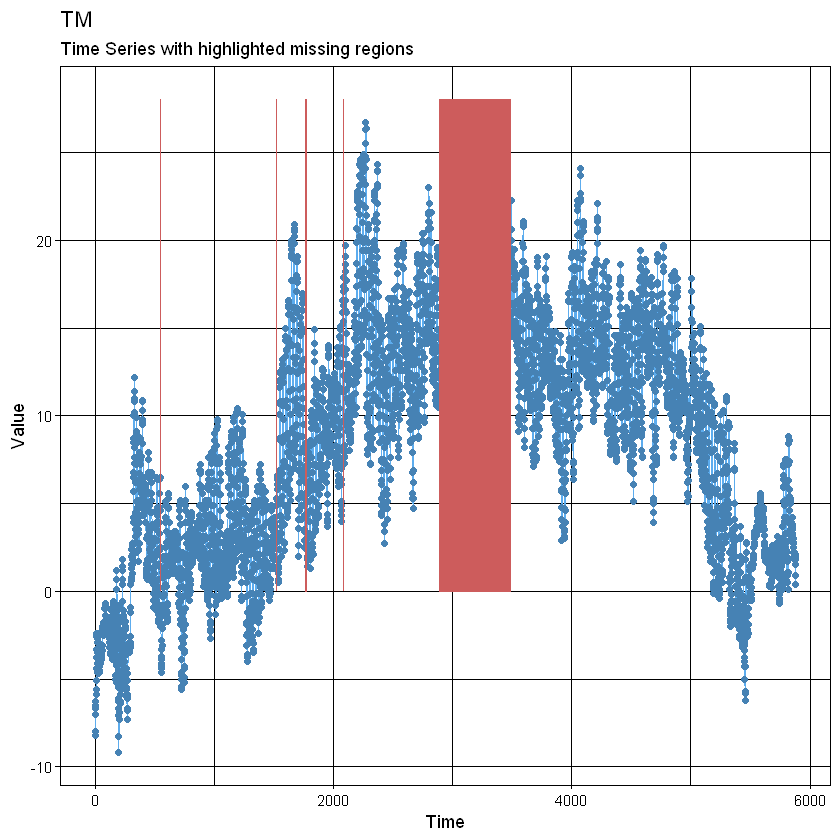

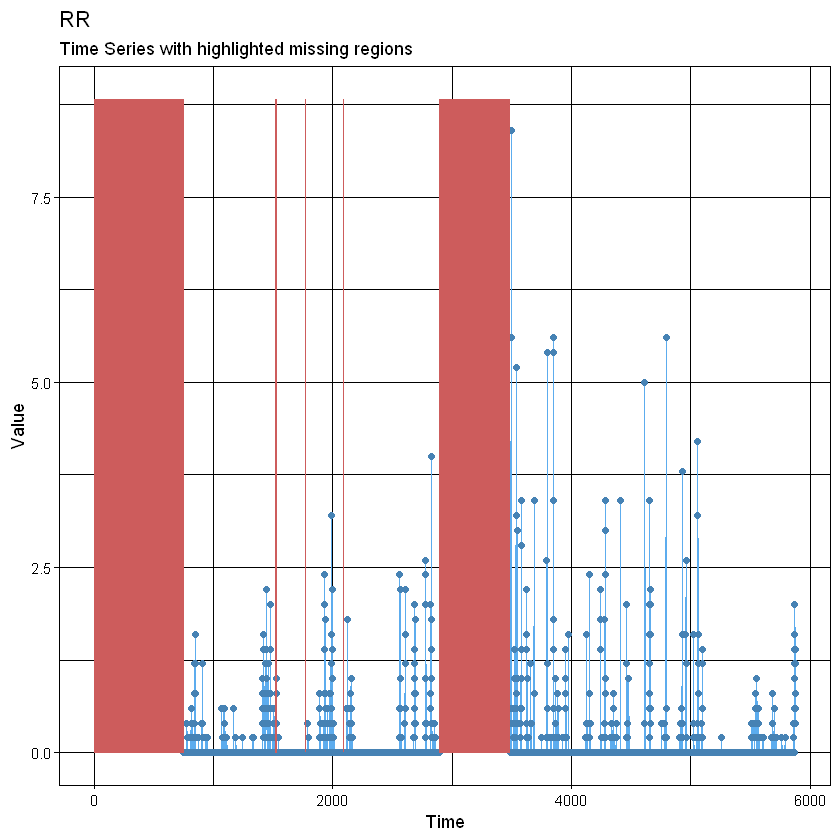

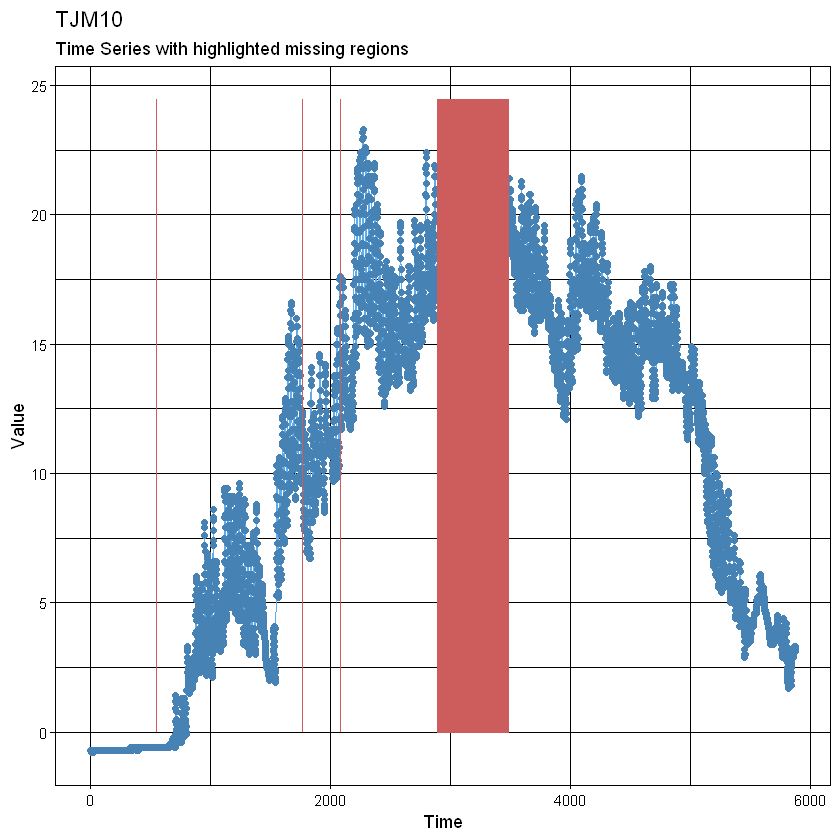

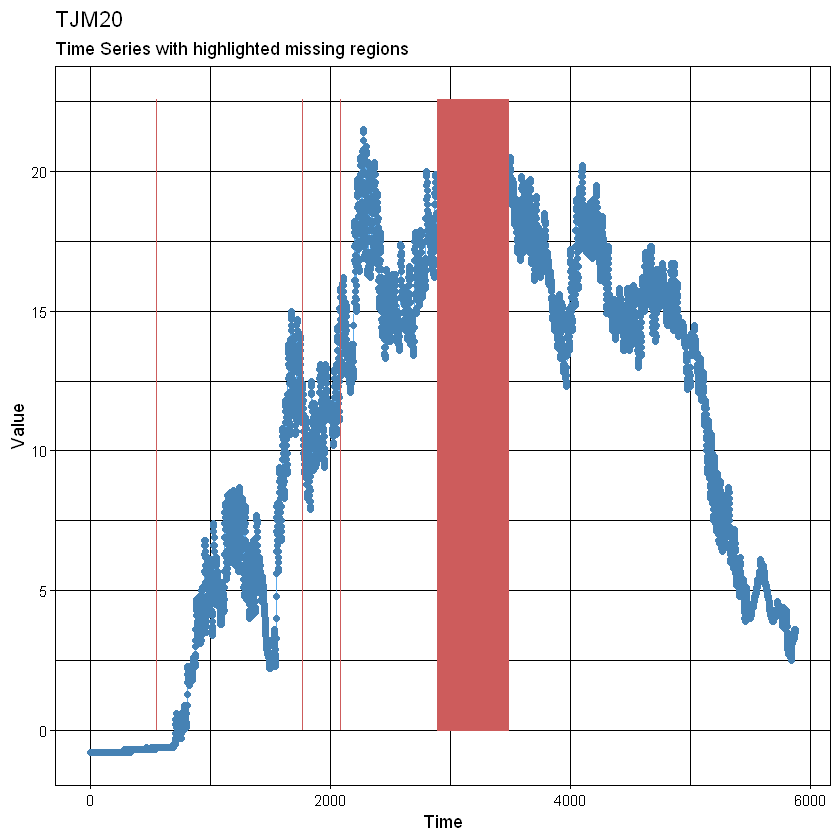

In [55]:
data_nibio <- data.nibio(18,2016)

for(col in c("TM","RR","TJM10","TJM20")){
    plot(ggplot_na_distribution(data_nibio[,col], color_missing="red", title=col))
}


In [122]:
# RR hadde ikke noe serlig, men hadde en rep ~= 31 (måned baser?)
# TM ~= 24? 
# TJM10 ~= 24?
# TJM20 ~= 21?
perid <- c(TM = 24,TJM10 = 24, TJM20 = 24, RR = 31)

data.rle <- rle(is.na(data_nibio[,"TJM20"]))
data.max <- max(data.rle$lengths[data.rle$values])
indexes <- find.index.rle.bool(data.rle,data.max)
print(data.max)

for(col in c("TJM20")){
    imput <- as.ts(na.interpol.cust(data_nibio[,col],n.p=perid[col]))
    plot(imput,xlim = c(indexes[1]-100,indexes[2]+100))
    abline(v=indexes[1],col = "red")
    abline(v=indexes[2],col = "red")
    title(paste(col,"STL + naive"))
}

for(col in c("TJM20")){
    imput <- as.ts(na_interpolation(data_nibio[,col]))
    plot(imput,xlim = c(indexes[1]-100,indexes[2]+100))
    abline(v=indexes[1],col = "red")
    abline(v=indexes[2],col = "red")
    title(paste(col,"naive"))
}


[1] 592


png 
  2

png 
  2

[1] 2893 3484

In [107]:
data.rle
#fit <- baggedModel(data.nibio(16,2017)[,"TM"],fn=auto.arima)
#fit <- ets(USAccDeaths)

Run Length Encoding
  lengths: int [1:9] 547 1 1220 1 317 1 805 592 2396
  values : logi [1:9] FALSE TRUE FALSE TRUE FALSE TRUE ...

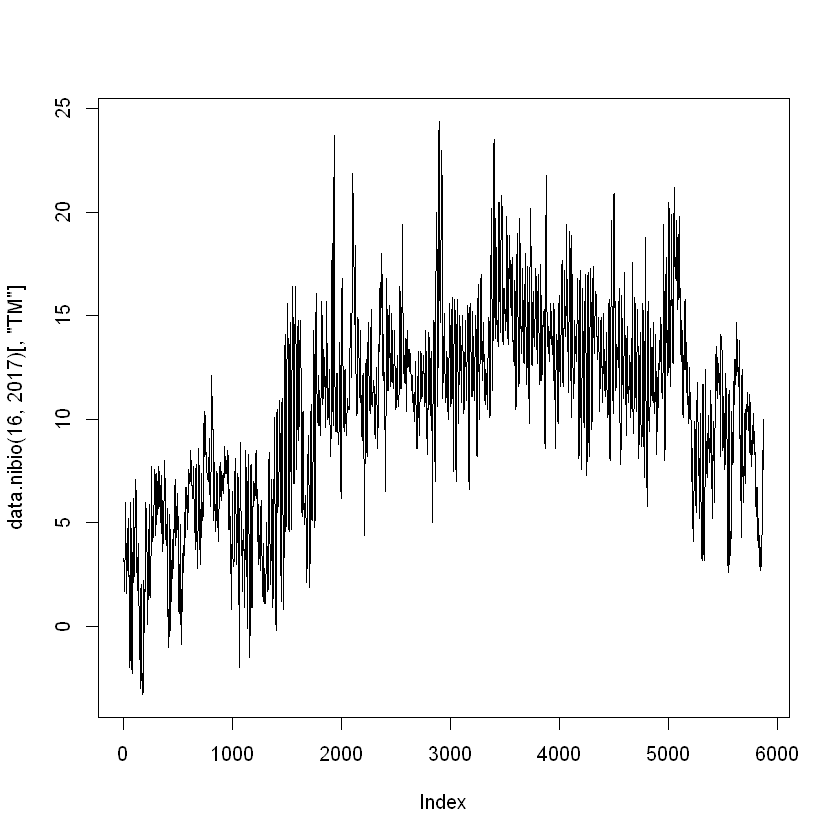

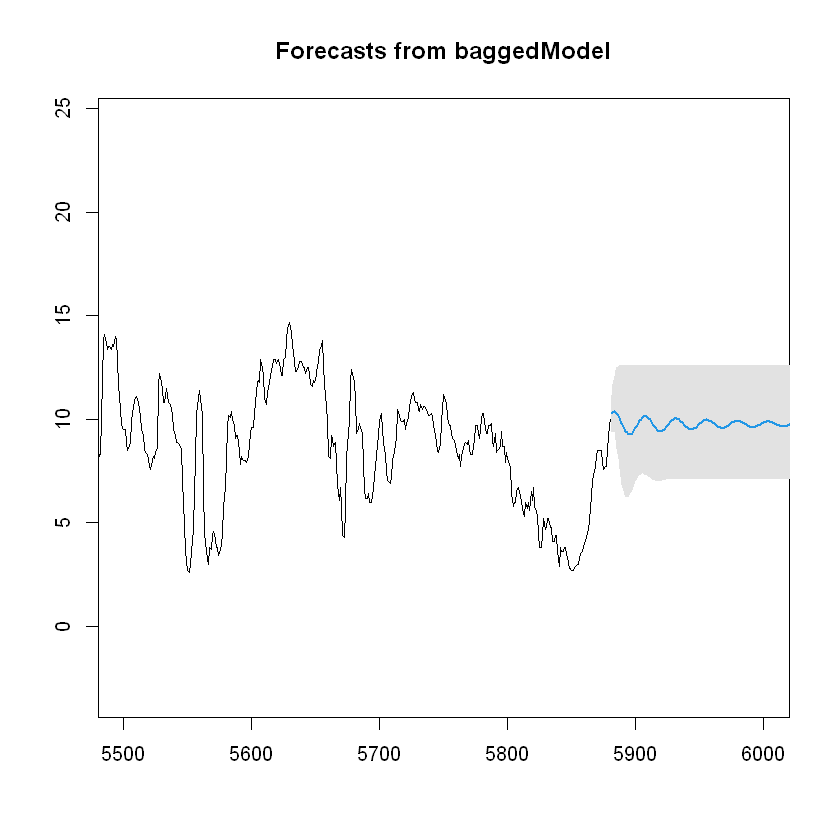

In [98]:
plot(data.nibio(16,2017)[,"TM"],type="l")
plot(forecast(fit,h=24*7),xlim=c(5500,6000))

In [34]:
imput_data <- na_interpolation(as.ts(data_nibio))

In [97]:
autoplot(imput_data)

ERROR: Error in eval(expr, envir, enclos): object 'imput_data' not found


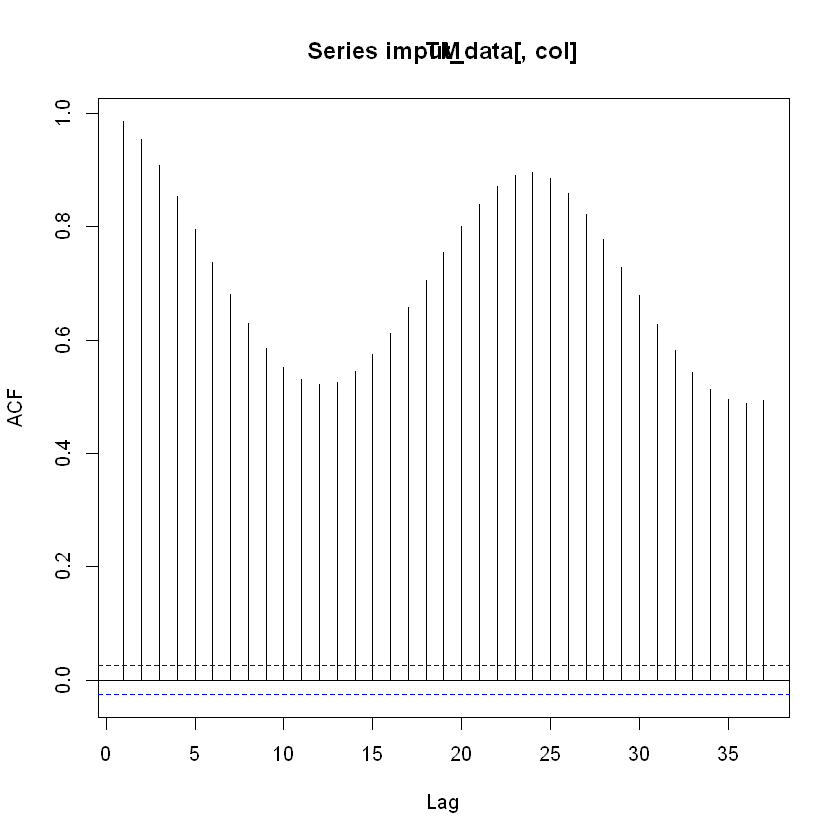

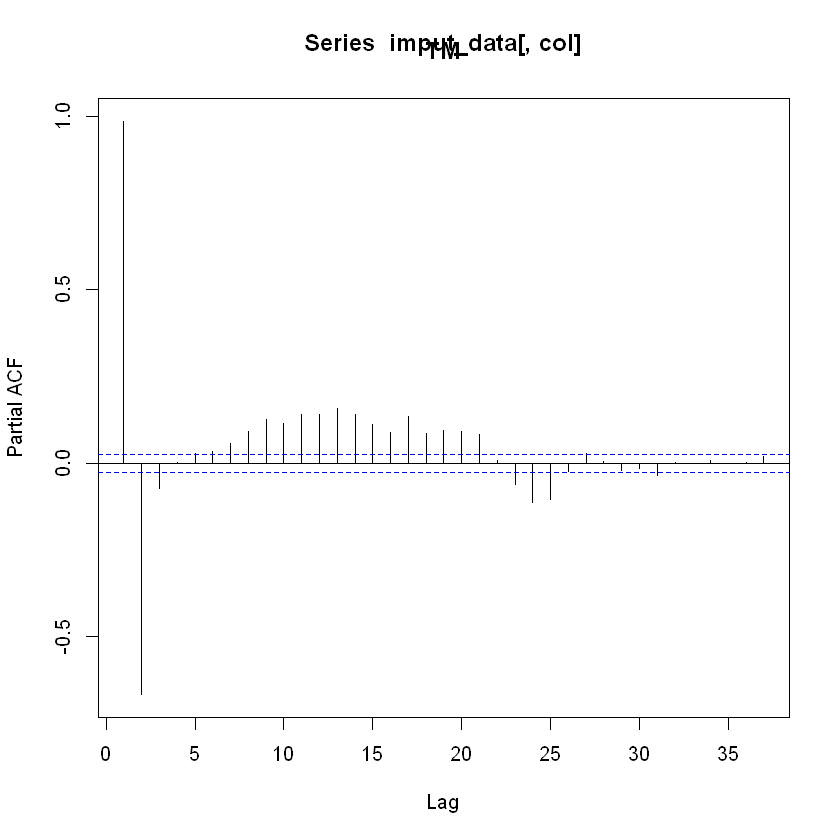

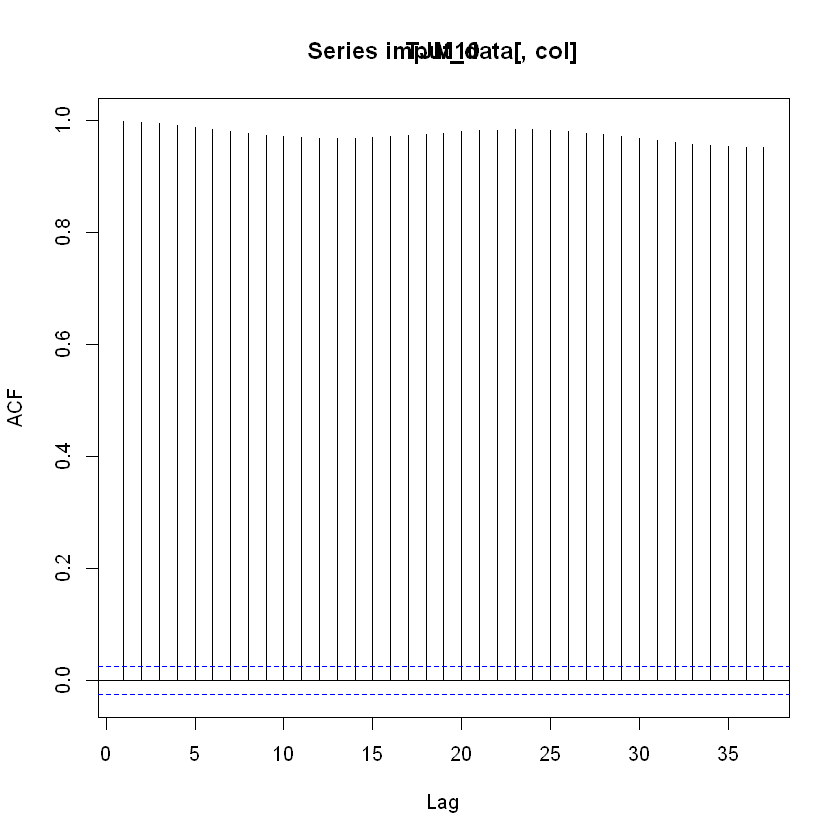

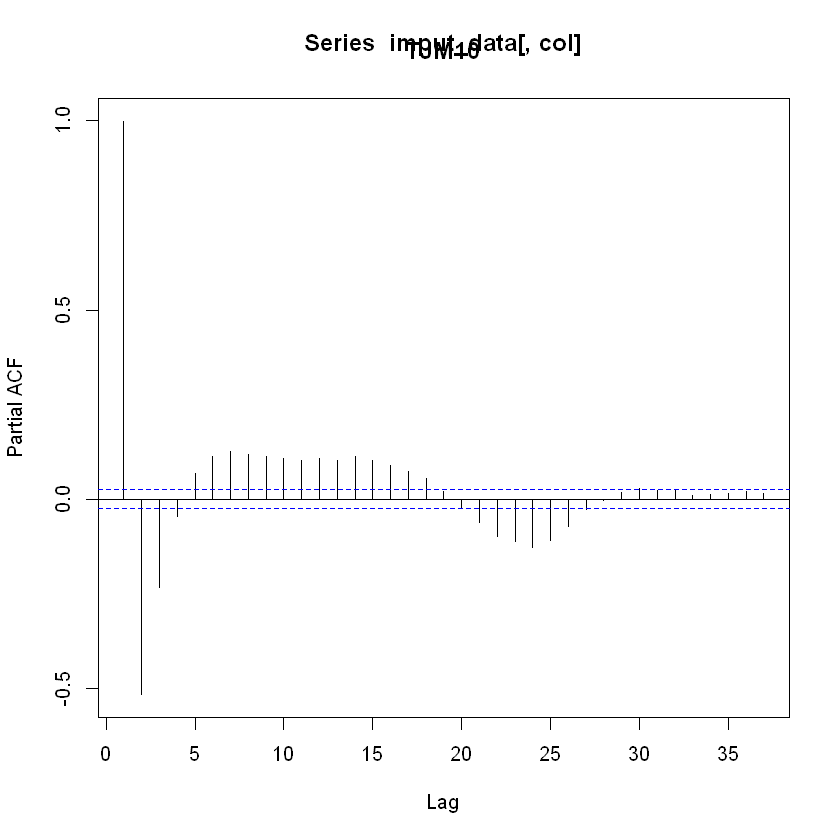

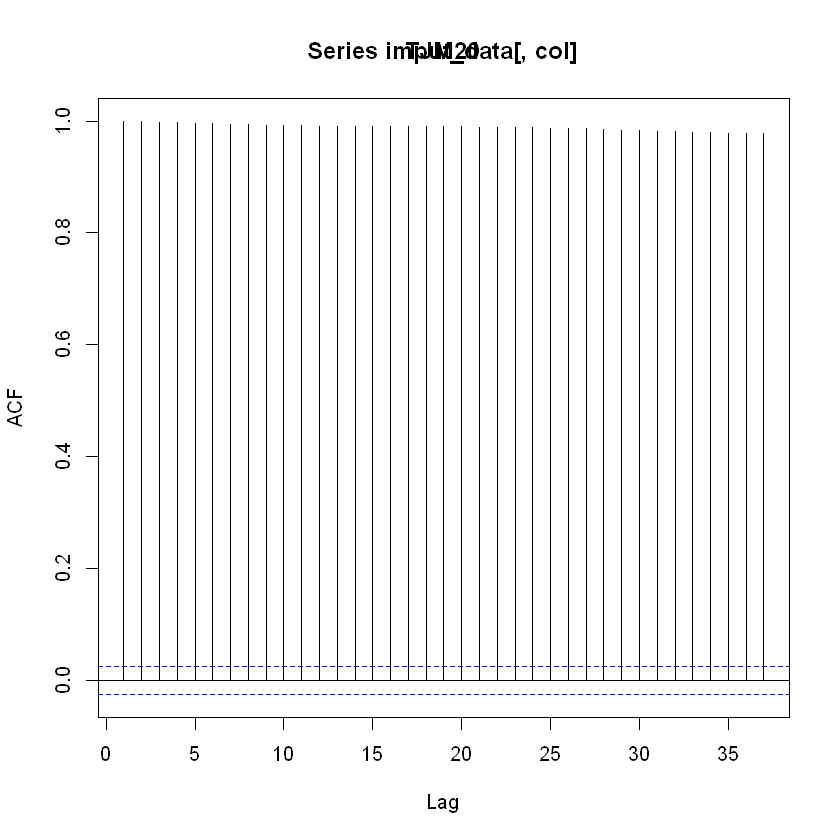

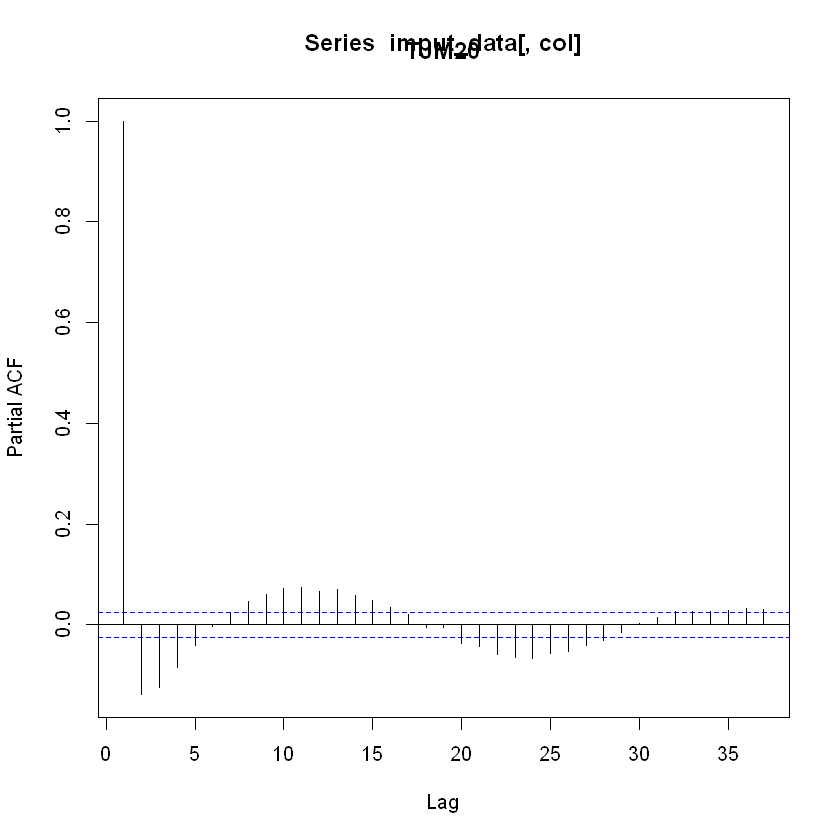

In [36]:
# RR hadde ikke noe serlig, men hadde en rep ~= 31 (måned baser?)
# TM ~= 24? 
# TJM10 ~= 24?
# TJM20 ~= 21?
for(col in c("TM","TJM10","TJM20")){
    acf(imput_data[,col])
    title(col)
    pacf(imput_data[,col])
    title(col)
}

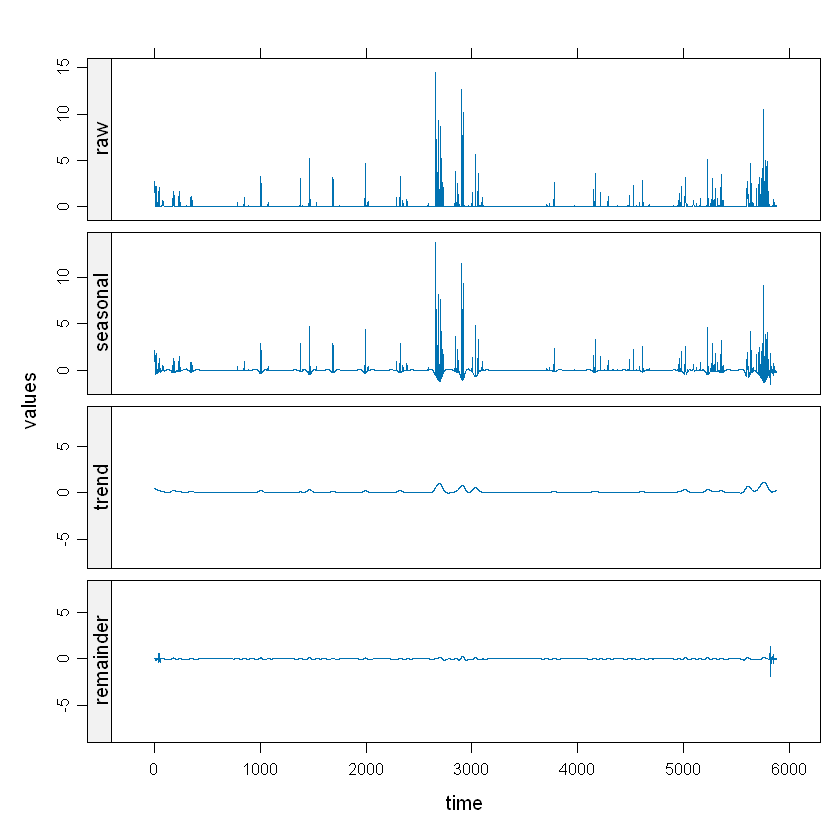

In [37]:
plot(stlplus::stlplus(imput_data[,"RR"],n.p = 31, s.window = 5,s.degree=2))

DEtte virker som nice statestik, men hvordan utvide dette til flere år når det er forskjellige vekstperioder? Kan jo prøve å dekomponere dem, så summere residualene under antagelsen at perioden for få stasjoner representerer ikke bare alle år, men alle stasjoner! Som er veldig grovt i min mening, men hva annet kan jeg gjøre.

In [38]:
data_stat_id = matrix()

for(id in nibio_id){
    csv_files <- list.files(path = DATA_COLLECTION_NIBIO,
                        pattern = regex(paste0(".*ID",id,"_y\\d{4}.csv")),
                                        full.names = TRUE)
    combined_data <- lapply(csv_files,
                        read.csv,
                        header=T, 
                        col.names = c("Time","TM","RR","TJM10","TJM20")) %>% bind_rows()
    combined_data <- combined_data %>% column_to_rownames(., var = 'Time')
    combined_data <- mutate_at(combined_data,c("TM","RR","TJM10","TJM20"), as.numeric)
}

ERROR: [1m[33mError[39m in `bind_rows()`:[22m
[33m![39m Can't combine `..1$TM` <double> and `..3$TM` <character>.


In [ ]:
library( datasets )
data("faithful")
# z - scores & M a h a l a n o b i s d i s t a n c e
z <- scale(imput_data) %>% as.data.frame()
mahalanobis(z , center = c(0 ,0) , cov = cov( imput_data,use = "all.obs" ) )
# DBSCAN & LOF
library( dbscan )
dbscan( imput_data , eps = 1)$cluster == 0
lof( imput_data , minPts = 5)
# I s o l a t i o n forest
library( isotree )
iso_mod <- isolation.forest( imput_data )
predict( iso_mod , newdata = imput_data )
# one - class SVM
library( e1071 )
svm_mod <- svm ( imput_data , type = "one-classification")
print(sum(predict( svm_mod , newdata = imput_data )))


In [26]:
?rbind

cbind {base},R Documentation
...,"(generalized) vectors or matrices. These can be given as named arguments. Other R objects may be coerced as appropriate, or S4 methods may be used: see sections ‘Details’ and ‘Value’. (For the ""data.frame"" method of cbind these can be further arguments to data.frame such as stringsAsFactors.)"
deparse.level,"integer controlling the construction of labels in the case of non-matrix-like arguments (for the default method): deparse.level = 0 constructs no labels; the default deparse.level = 1 typically and deparse.level = 2 always construct labels from the argument names, see the ‘Value’ section below."
make.row.names,(only for data frame method:) logical indicating if unique and valid row.names should be constructed from the arguments.
stringsAsFactors,"logical, passed to as.data.frame; only has an effect when the ... arguments contain a (non-data.frame) character."
factor.exclude,"if the data frames contain factors, the default TRUE ensures that NA levels of factors are kept, see PR#17562 and the ‘Data frame methods’. In R versions up to 3.6.x, factor.exclude = NA has been implicitly hardcoded (R <= 3.6.0) or the default (R = 3.6.x, x >= 1)."


Warning message in stats::StructTS(data, ...):
"possible convergence problem: 'optim' gave code = 52 and message 'ERROR: ABNORMAL_TERMINATION_IN_LNSRCH'"
Warning message in stats::StructTS(data, ...):
"possible convergence problem: 'optim' gave code = 52 and message 'ERROR: ABNORMAL_TERMINATION_IN_LNSRCH'"


[1] "f1 = TM f2 = RR"
[1] "f1 = TM f2 = TJM10"


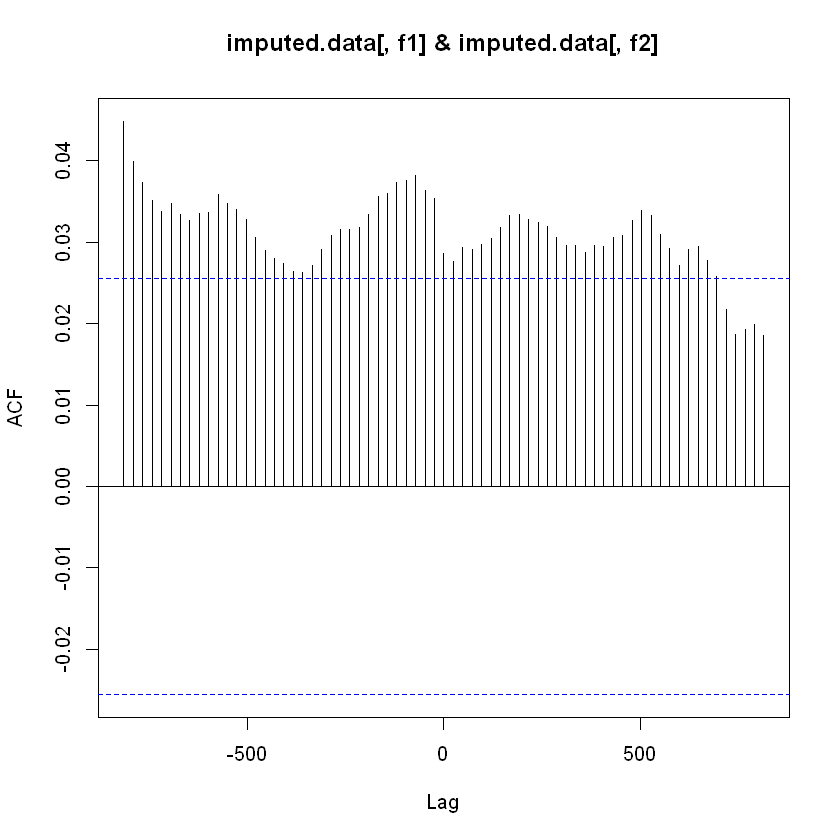

[1] "f1 = TM f2 = TJM20"


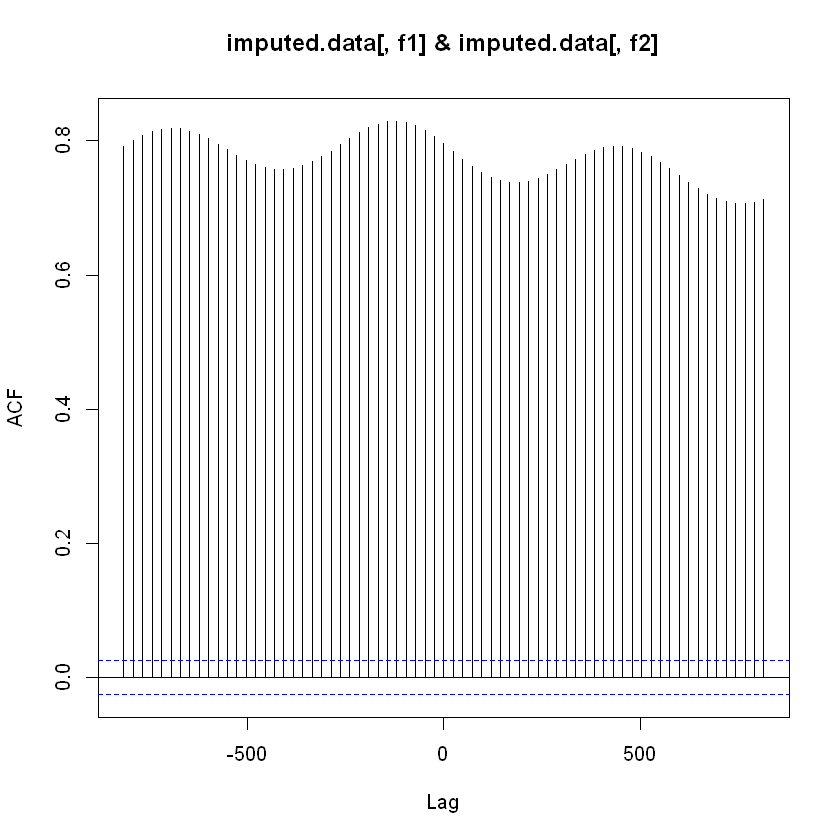

[1] "f1 = RR f2 = TJM10"


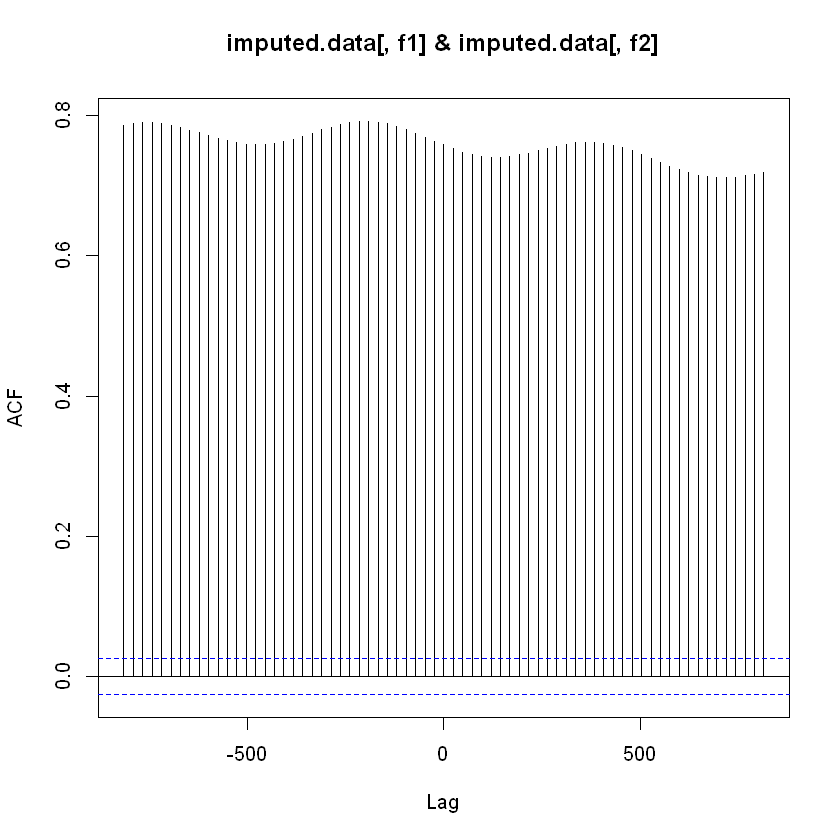

[1] "f1 = RR f2 = TJM20"


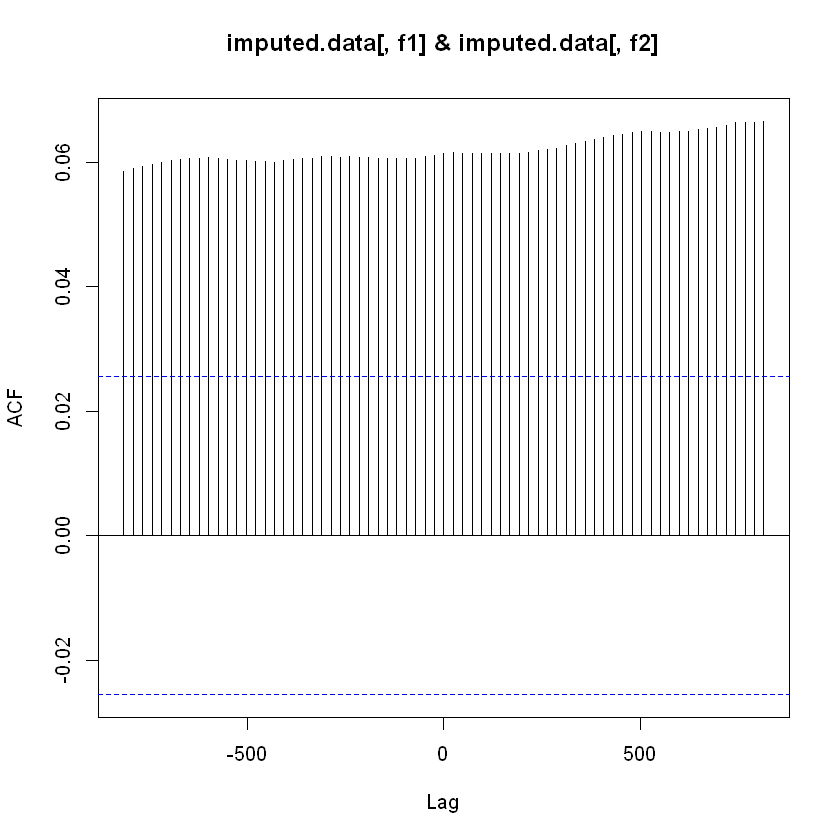

[1] "f1 = TJM10 f2 = TJM20"


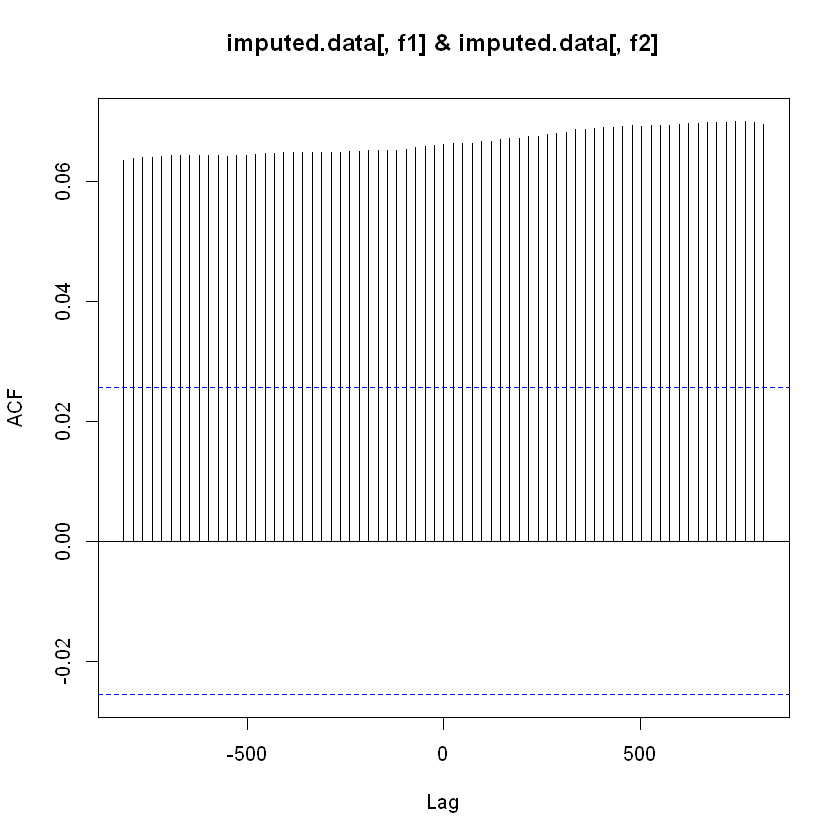

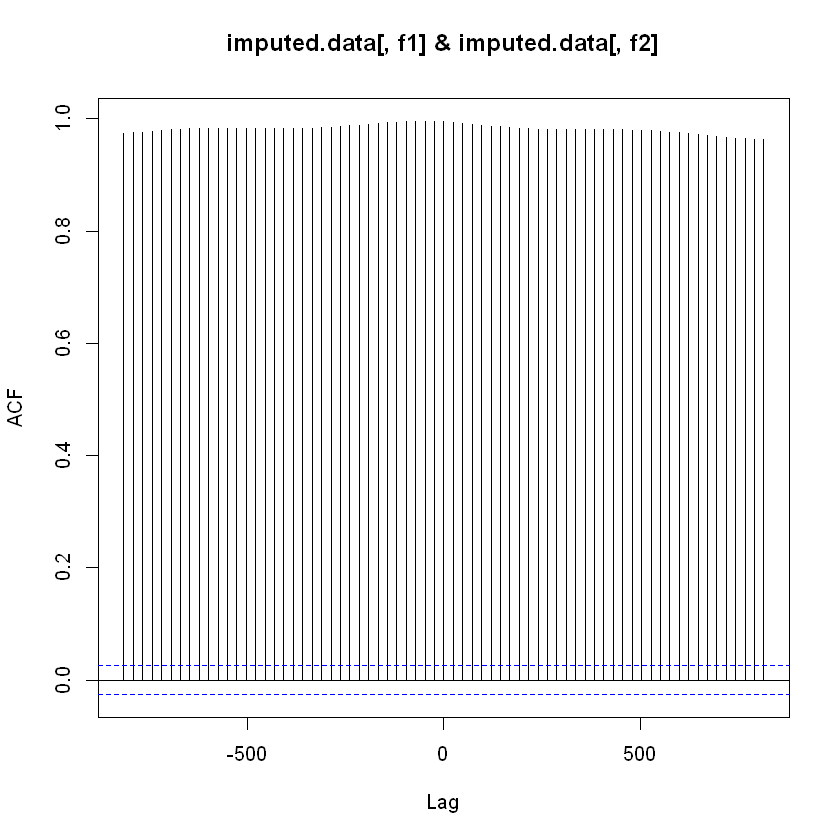

In [38]:
feature.name = c("TM","RR","TJM10","TJM20")

imputed.data <- na_seasplit(ts(subset(data_nibio,select=-Time),frequency=1/24),algorithm = "kalman")
for(col1 in 1:4){
    for(col2 in col1:4){
        if(col1 != col2){
            f1 <- feature.name[col1]
            f2 <- feature.name[col2]
            print(paste("f1 =",f1,"f2 =",f2))
            ccf(imputed.data[,f1],imputed.data[,f2])
        }
    }
}

In [ ]:
adf.test(imputed.data[,"TJM10"])
kpss.test(imputed.data[,"TJM10"])
pp.test(imputed.data[,"TJM10"])

In [ ]:
plot(runner( data_nibio[,"TM"] , f = function( x ) { m <- auto.arima(x)
                                        pred <- forecast(m , 1)$mean
                                        return( pred ) } , at = 10:5879) - data_nibio[-c(1:10),"TM"],type = "l")